# DDA 4230 Tutorial 8

## Section 0:  Outline
1. Linear Value-function Approximation (Linear VFA)
2. Brief Introduction to Neural Network


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gridWorldGame import standard_grid, negative_grid,print_values, print_policy

SMALL_ENOUGH = 1e-3
GAMMA = 0.9
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R')
ALPHA = 0.1
SA2IDX = {}
IDX = 0

## Section 1: Linear Value Function Approximation

We have represented value function by a lookup table where each state has a corresponding entry $V(s)$ or each state-action pair has an entry $Q(s,a)$. However, the above approach might not generalize well to problems with very large state and action spaces. To solve this problem, a large  number of approximation methods are proposed.

The benefits of value-function approximation are obvious. 
* Smaller storage requirements since only the parameters $w$ need to be stored along with a compact description of the functional form of the architecture. In general, for most approximation architectures, the storage needs are independent of the size of the state space and/or the size of the action space. 
* No restriction on the state space to be a finite set for most approximation architectures;
* Good generalization abilities. Function approximation has larger flexibility and may speed up learning in finite problems, due to the fact that the algorithm can generalize earlier experiences to unseen states.

Consider a Linear function approximation. Each state/ state-action pair is represented/encoded to a feature vector
$$x(s)=(x_1(s),x_2(s),...,x_d(s))^T$$
where d is the dimensionality of the feature space. We then approximate our value functions using a linear combination of features as
$$x(s)w=\sum_{j=1}^d x_j(s)w_j$$

Since the choice of feature vectors is beyond of our course, the feature vectors are given in this tutorial. 
If you are interested in such topic, please refer to the area of feature embedding.



### 1.1 Model Construction

Now, we turn to Q-learning with Linear function approximation which has update rule
$$w_{t+1}(s_t,a_t)=w_{t}(s_t,a_t)+\alpha_t(r_t+\gamma \max _{s,a} Q(s,a)-Q(s_t,a_t))\nabla Q_{t}(s_t,a_t)$$

In [2]:
class LinearVFA:
    def __init__(self):
        self.theta = np.random.randn(25) / np.sqrt(25)

    def sa2x(self, s, a):
        return np.array([
        s[0] - 1              if a == 'U' else 0,
        s[1] - 1.5            if a == 'U' else 0,
        (s[0]*s[1] - 3)/3     if a == 'U' else 0,
        (s[0]*s[0] - 2)/2     if a == 'U' else 0,
        (s[1]*s[1] - 4.5)/4.5 if a == 'U' else 0,
        1                     if a == 'U' else 0,
        s[0] - 1              if a == 'D' else 0,
        s[1] - 1.5            if a == 'D' else 0,
        (s[0]*s[1] - 3)/3     if a == 'D' else 0,
        (s[0]*s[0] - 2)/2     if a == 'D' else 0,
        (s[1]*s[1] - 4.5)/4.5 if a == 'D' else 0,
        1                     if a == 'D' else 0,
        s[0] - 1              if a == 'L' else 0,
        s[1] - 1.5            if a == 'L' else 0,
        (s[0]*s[1] - 3)/3     if a == 'L' else 0,
        (s[0]*s[0] - 2)/2     if a == 'L' else 0,
        (s[1]*s[1] - 4.5)/4.5 if a == 'L' else 0,
        1                     if a == 'L' else 0,
        s[0] - 1              if a == 'R' else 0,
        s[1] - 1.5            if a == 'R' else 0,
        (s[0]*s[1] - 3)/3     if a == 'R' else 0,
        (s[0]*s[0] - 2)/2     if a == 'R' else 0,
        (s[1]*s[1] - 4.5)/4.5 if a == 'R' else 0,
        1                     if a == 'R' else 0,
        1
      ])

    def predict(self, s, a):
        x = self.sa2x(s, a)
        return self.theta.dot(x)


    def grad(self, s, a):
        return self.sa2x(s, a)
    
def getQs(model, s):
    '''
    Return all Q value w.r.t given state s 
    used for choosing action and finding policy
    '''
    Qs = {}
    for a in ALL_POSSIBLE_ACTIONS:
        q_sa = model.predict(s, a)
        Qs[a] = q_sa
    return Qs  

def max_dict(d):
    # Find the largest Q value and the corresponding action
    max_key = None
    max_val = float('-inf')
    for k, v in d.items():
        if v > max_val:
            max_val = v
            max_key = k
    return max_key, max_val

def random_action(a, eps=0.1):
  # Epsilon-soft to ensure all states are visited
    p = np.random.random()
    if p < (1 - eps):
        return a
    else:
        return np.random.choice(ALL_POSSIBLE_ACTIONS)

### 1.2 Evaluation

In [3]:
grid = negative_grid(step_cost=-0.1)
print("Rewards Map:")
print_values(grid.rewards, grid)

Rewards Map:
---------------------------
-0.10|-0.10|-0.10| 1.00|
---------------------------
-0.10| 0.00|-0.10|-1.00|
---------------------------
-0.10|-0.10|-0.10|-0.10|


Note: In general, before feature encoding and function approximation, we need first convert state/state-values to some numerical values. Then, these numerical values can be used for indexing or feature embedding.

In [4]:
# Convert state-action to index
states = grid.all_states()
for s in states:
    SA2IDX[s] = {}
    for a in ALL_POSSIBLE_ACTIONS:
        SA2IDX[s][a] = IDX
        IDX += 1
print(SA2IDX)

{(0, 1): {'U': 0, 'D': 1, 'L': 2, 'R': 3}, (1, 2): {'U': 4, 'D': 5, 'L': 6, 'R': 7}, (0, 0): {'U': 8, 'D': 9, 'L': 10, 'R': 11}, (1, 3): {'U': 12, 'D': 13, 'L': 14, 'R': 15}, (2, 1): {'U': 16, 'D': 17, 'L': 18, 'R': 19}, (2, 0): {'U': 20, 'D': 21, 'L': 22, 'R': 23}, (2, 3): {'U': 24, 'D': 25, 'L': 26, 'R': 27}, (2, 2): {'U': 28, 'D': 29, 'L': 30, 'R': 31}, (1, 0): {'U': 32, 'D': 33, 'L': 34, 'R': 35}, (0, 2): {'U': 36, 'D': 37, 'L': 38, 'R': 39}, (0, 3): {'U': 40, 'D': 41, 'L': 42, 'R': 43}}


In [5]:
# Initialize model
model = LinearVFA()

In [6]:
# repeat until convergence
t = 1.0 # Shrink parameter for eps-greedy
t2 = 1.0 # Shrink parameter for Learning rate
deltas = []
for it in range(50000):
    if it % 100 == 0:
        t += 0.01
        t2 += 0.01
    if it % 1000 == 0:
        print("iteration:", it, end='->')
    alpha = ALPHA / t2 # Learning rate shrink over time
    s = (2, 0) # start state
    grid.set_state(s)

    Qs = getQs(model, s)

    a = max_dict(Qs)[0] # First step
    a = random_action(a, eps=0.5/t) # epsilon-greedy
    biggest_change = 0
    while not grid.game_over():
        r = grid.move(a)
        s2 = grid.current_state()
        old_theta = model.theta.copy()
        # Terminal state has Q value 0
        if grid.is_terminal(s2):
            model.theta += alpha*(r - model.predict(s, a))*model.grad(s, a)
        else:
            # not terminal
            Qs2 = getQs(model, s2)
            a2, maxQs2a2 = max_dict(Qs2)
            a2 = random_action(a2, eps=0.5/t) # epsilon-greedy

            model.theta += alpha*(r + GAMMA*maxQs2a2 - model.predict(s, a))*model.grad(s, a)
            s = s2
            a = a2

    biggest_change = max(biggest_change, np.abs(model.theta - old_theta).sum())
    deltas.append(biggest_change)
print("Done")

iteration: 0->iteration: 1000->iteration: 2000->iteration: 3000->iteration: 4000->iteration: 5000->iteration: 6000->iteration: 7000->iteration: 8000->iteration: 9000->iteration: 10000->iteration: 11000->iteration: 12000->iteration: 13000->iteration: 14000->iteration: 15000->iteration: 16000->iteration: 17000->iteration: 18000->iteration: 19000->iteration: 20000->iteration: 21000->iteration: 22000->iteration: 23000->iteration: 24000->iteration: 25000->iteration: 26000->iteration: 27000->iteration: 28000->iteration: 29000->iteration: 30000->iteration: 31000->iteration: 32000->iteration: 33000->iteration: 34000->iteration: 35000->iteration: 36000->iteration: 37000->iteration: 38000->iteration: 39000->iteration: 40000->iteration: 41000->iteration: 42000->iteration: 43000->iteration: 44000->iteration: 45000->iteration: 46000->iteration: 47000->iteration: 48000->iteration: 49000->Done


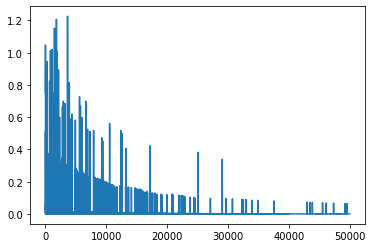

In [7]:
plt.plot(deltas)
plt.show()

Note: As discussed in LN15, the convergence of such a Linear VFA based Q-learning is not guaranteed.

In [8]:
# determine the policy from Q*
# find V* from Q*
policy = {}
V = {}
Q = {}
for s in grid.actions.keys():
    Qs = getQs(model, s)
    Q[s] = Qs
    a, max_q = max_dict(Qs)
    policy[s] = a
    V[s] = max_q

In [9]:
print("final values:")
print_values(V, grid)
print("final policy:")
print_policy(policy, grid)

final values:
---------------------------
 0.62| 0.80| 1.00| 0.00|
---------------------------
 0.46| 0.00| 0.71| 0.00|
---------------------------
 0.31| 0.17| 0.33| 0.80|
final policy:
---------------------------
  R  |  R  |  R  |     |
---------------------------
  U  |     |  U  |     |
---------------------------
  U  |  U  |  U  |  U  |


## Section 2: Brief Introduction to Neural Network

* What is (Artificial) Neural Network?
   - In general, Neural Network is a class of non-linear function $f(x)$.
Example
<img src="https://i.loli.net/2021/04/06/PsCRpkU6TVO3jmg.png" style="width: 500px;" center/>
We have
$$z_j=\sigma \left(\sum_{i=0}^Dx_iw^{(1)}_{i,j}\right), \forall j=1,2,...M$$
$$y_k=\sigma \left(\sum_{j=0}^Mz_jw^{(2)}_{j,k}\right), \forall k=1,2,...M$$
So, 
$$f_k(x)=y_k=\sigma \left(z_0w^{(2)}_{0,k}+\sum_{j=1}^M\sigma \left(\sum_{i=0}^Dx_iw^{(1)}_{i,j}\right)w^{(2)}_{j,k}\right), \forall k=1,2,...M$$
where $\sigma$ is a nonlinear function called activation function such as Sigmoid and Relu.

Each node in the graph is called a neuron.
    

* Why do we need Neural Network?
   - Theoretically, ANN can approximate any function by universal approximation theorems.

### 2.1 Forward & backward Propogation 

* Forward Propogation 
    - Given $x$, return $f(x)$
* Back Propogation:
    - Calculate the gradient of each parameter using Chain Rule.

Example:
Consider a neural network as below:
    
<img src="https://i.loli.net/2021/04/06/cRH3IJKOlPpysth.png" style="width: 800px;" center/>
Forward Propogation: Green

Backward Propogation: Red


In [10]:
# Last Neuron
1*-1/(1.37)**2*np.exp(-1)

-0.1960037514899261

### 2.2 Regression using Neural Network
Find f minimize (f(X)-Y)^2

In [11]:
def sigmoid(x):
    s=1.0/(1.0+1.0/np.exp(x))
    ds=s*(1-s)
    return s

N, D_in, H, D_out = 1000, 1, 200, 1

x = np.random.randn(N, D_in)  
y=np.sin(np.pi*x)
w1 = np.random.randn(D_in, H)  
w2 = np.random.randn(H, D_out)

learning_rate = 1e-5
for it in range(20000):
    # Forward pass  
    h = x.dot(w1) # N * H     
    h_s=sigmoid(h) # Sigmoid
    y_pred = h_s.dot(w2) # N * D_out   
    
    # compute loss  
    loss = np.square(y_pred - y).sum()
    print(it, loss)
    
    # Backward pass  
    # compute the gradient
    grad_y_pred = 2.0 * (y_pred - y)  
    grad_w2 = h_s.T.dot(grad_y_pred) 
    grad_h_s = grad_y_pred.dot(w2.T) 
    grad_s= h_s*(1-h_s)*grad_h_s 
    grad_w1 = x.T.dot(grad_s)
    
    # update weights of w1 and w2
    w1 -= learning_rate * grad_w1
    w2 -= learning_rate * grad_w2


0 14281.971028868833
1 6936.4386060631805
2 3989.269766280333
3 2365.1462848203673
4 1470.5004486837443
5 977.813715663142
6 706.49574972602
7 557.0370426352442
8 474.6362024128883
9 429.1269384629866
10 403.9096668371597
11 389.85266856097553
12 381.9334850545514
13 377.39019493074795
14 374.7041564738656
15 373.04041503327153
16 371.9399350066371
17 371.15035809866094
18 370.5329480829432
19 370.01143012172747
20 369.54386504794206
21 369.10718792170985
22 368.6887087712763
23 368.2814406141585
24 367.88153135305834
25 367.48685215256
26 367.09622151101644
27 366.7089787572388
28 366.32474961502515
29 365.9433173407675
30 365.5645518907886
31 365.18837098553956
32 364.81471870640297
33 364.4435537296207
34 364.074842857495
35 363.7085574613999
36 363.3446715253937
37 362.98316056969065
38 362.6240010578197
39 362.26717006969443
40 361.91264512088276
41 361.5604040622703
42 361.21042502393664
43 360.86268638335764
44 360.51716674699486
45 360.17384493926045
46 359.8326999955496
47 359

KeyboardInterrupt: 

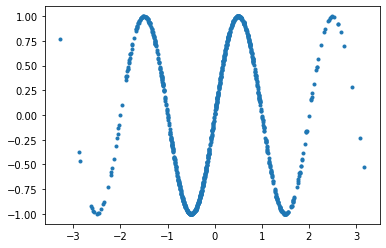

In [12]:
plt.plot(x,y,'.')

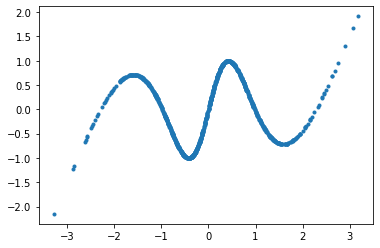

In [13]:
plt.plot(x,y_pred,'.')

### Acknowledge
Part of this tutorial is adapted from https://github.com/lazyprogrammer/machine_learning_examples/tree/master/rl and https://cs231n.github.io/optimization-2/